In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


In [176]:
import numpy as np
# Cargar el dataset
df = pd.read_csv("https://raw.githubusercontent.com/shotokan/spam-classifier/refs/heads/main/data/sms.tsv", sep="\t", names=["label", "message"])
print(df)


     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [177]:
# Cargar segundo dataset
temporal_df = pd.read_csv("https://raw.githubusercontent.com/shotokan/spam-classifier/refs/heads/main/data/ham-spam.csv")
second_df = temporal_df.rename(columns={
    "IsSpam": "label",
    "Text": "message"
})
second_df["label"] = second_df["label"].map({0: "ham", 1: "spam"})
print(second_df)

    label                                            message
0     ham  key issues going forwarda year end reviews rep...
1     ham  congrats contratulations the execution the cen...
2     ham   key issues going forwardall under control set...
3     ham  epmi files protest entergy transcoattached our...
4     ham  california power please contact kristin walsh ...
..    ...                                                ...
995  spam  somebody nort offlce pro offlce ado phot shop ...
996  spam   utf present day course utf reduce mass this p...
997  spam   sell regalis for affordable pricehi regalis a...
998  spam  email exclusive complimentary satellite dish w...
999  spam  unfeigned alilum ciall ambiien aagrra xaanax c...

[1000 rows x 2 columns]


In [178]:
# Mezclar los dataset para teber un dataset con mas datos
merged_df = pd.concat([df, second_df], ignore_index=True)
print(merged_df)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
6567  spam  somebody nort offlce pro offlce ado phot shop ...
6568  spam   utf present day course utf reduce mass this p...
6569  spam   sell regalis for affordable pricehi regalis a...
6570  spam  email exclusive complimentary satellite dish w...
6571  spam  unfeigned alilum ciall ambiien aagrra xaanax c...

[6572 rows x 2 columns]


In [179]:
merged_df.isnull().sum()

,0
label,0
message,0


In [180]:
merged_df.duplicated().sum()

np.int64(404)

In [181]:
merged_df = merged_df.drop_duplicates()
merged_df.duplicated().sum()

np.int64(0)

In [182]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

In [183]:
from posixpath import defpath
# Preprocesamiento
merged_df["message_length"] = merged_df["message"].apply(len) # Calcula la longitud total del mensaje y genera una nueva

# Calcula el porcentaje de letras en mayúsculas en el mensaje
merged_df["uppercase_ratio"] = merged_df["message"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x))

# Cuenta cuántos signos de puntuación hay en el mensaje
merged_df["punctuation_count"] = merged_df["message"].apply(lambda x: sum(1 for c in x if c in string.punctuation))


# Preprocesamiento
df["message_length"] = df["message"].apply(len) # Calcula la longitud total del mensaje y genera una nueva

# Calcula el porcentaje de letras en mayúsculas en el mensaje
df["uppercase_ratio"] = df["message"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x))

# Cuenta cuántos signos de puntuación hay en el mensaje
df["punctuation_count"] = df["message"].apply(lambda x: sum(1 for c in x if c in string.punctuation))

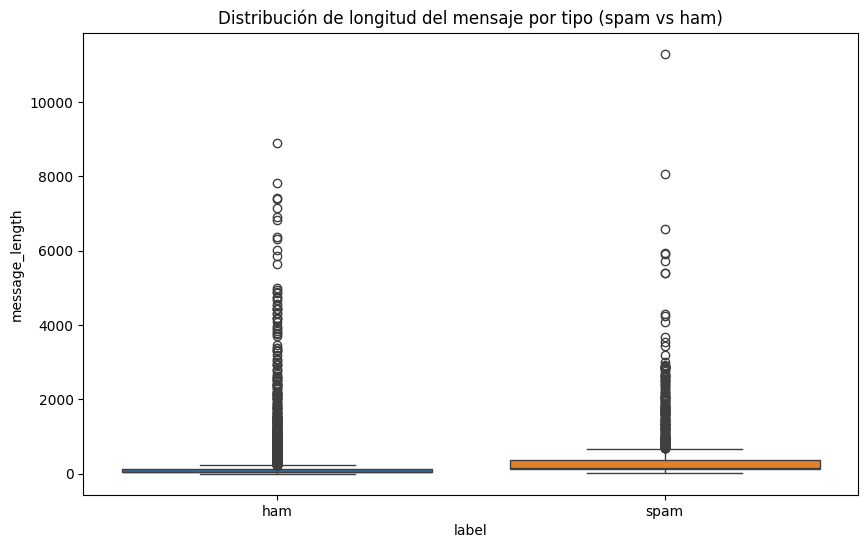

In [184]:
plt.figure(figsize=(10,6))
sns.boxplot(data=merged_df, x="label", y="message_length", hue="label")
plt.title("Distribución de longitud del mensaje por tipo (spam vs ham)")
plt.show()

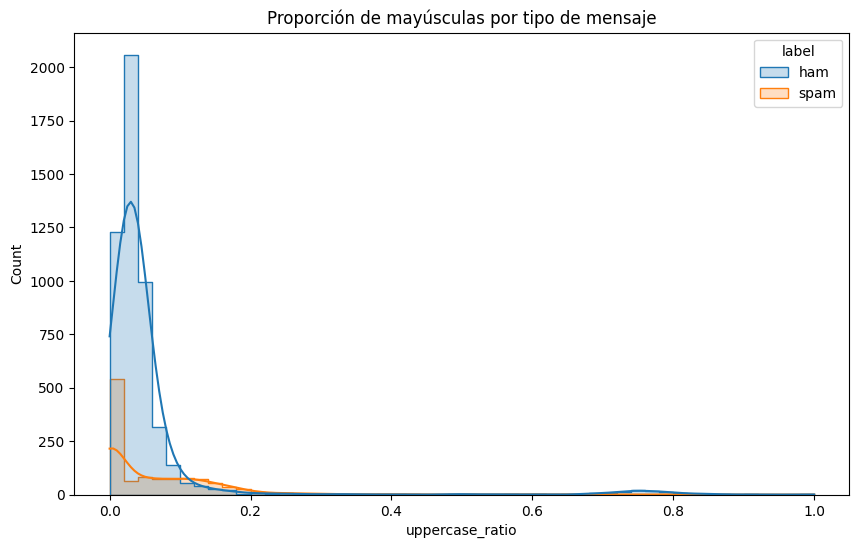

In [185]:
plt.figure(figsize=(10,6))
sns.histplot(data=merged_df, x="uppercase_ratio", hue="label", bins=50, kde=True, element="step")
plt.title("Proporción de mayúsculas por tipo de mensaje")
plt.show()

Los correos spam suelen tener más mayúsculas

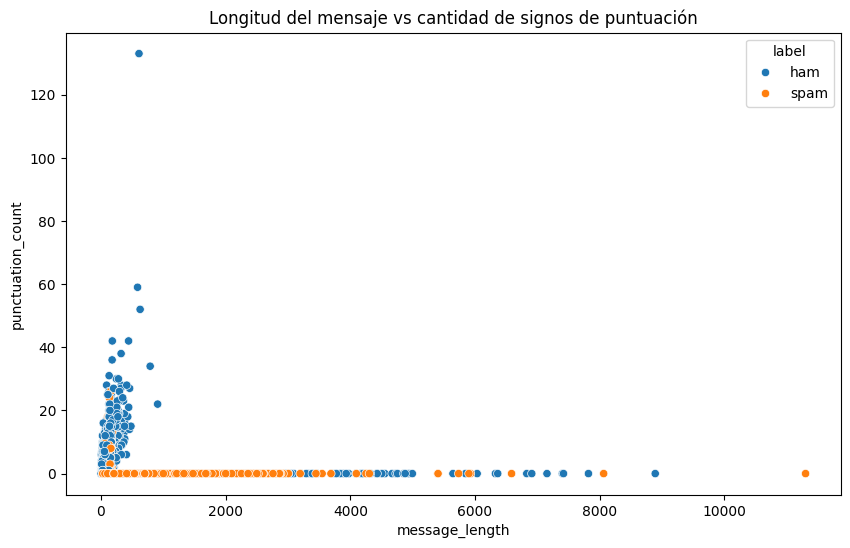

In [186]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_df, x="message_length", y="punctuation_count", hue="label")
plt.title("Longitud del mensaje vs cantidad de signos de puntuación")
plt.show()

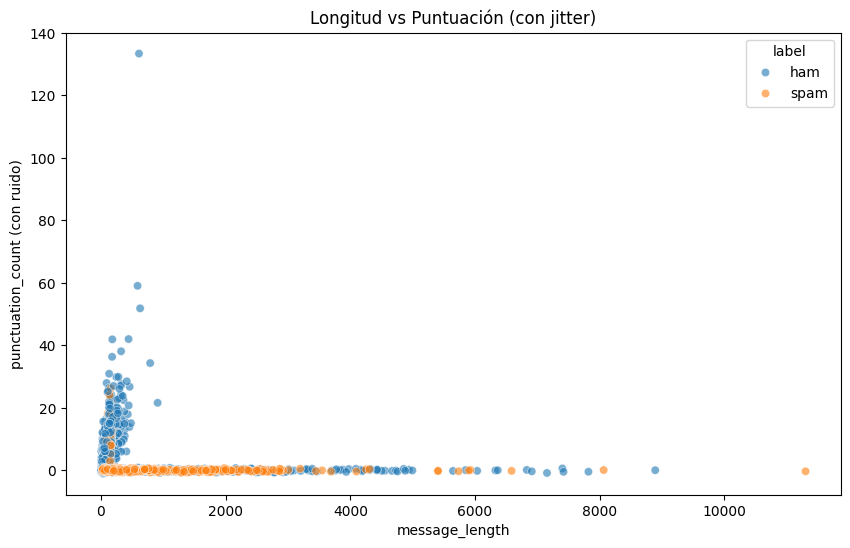

In [187]:
merged_df_jitter = merged_df.copy()
merged_df_jitter["punctuation_count_jitter"] = merged_df["punctuation_count"] + np.random.normal(0, 0.3, size=len(merged_df))

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged_df_jitter,
    x="message_length",
    y="punctuation_count_jitter",
    hue="label",
    alpha=0.6
)
plt.title("Longitud vs Puntuación (con jitter)")
plt.xlabel("message_length")
plt.ylabel("punctuation_count (con ruido)")
plt.show()

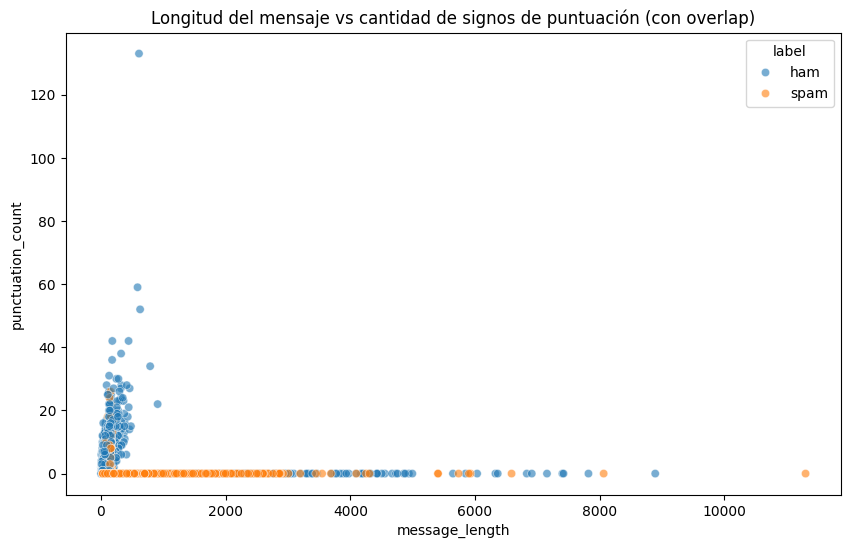

In [188]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged_df,
    x="message_length",
    y="punctuation_count",
    hue="label",
    alpha=0.6  # transparencia para ver solapamientos
)
plt.title("Longitud del mensaje vs cantidad de signos de puntuación (con overlap)")
plt.show()

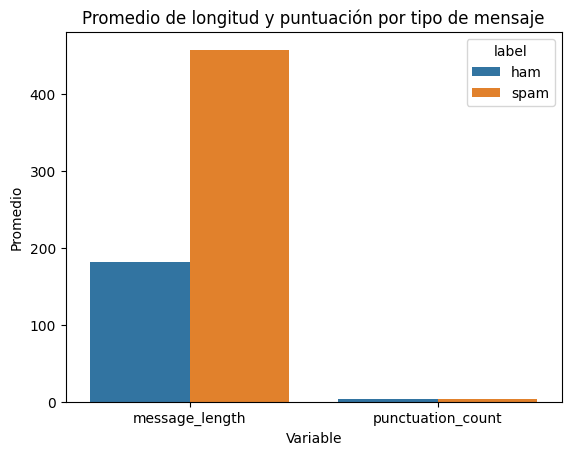

In [189]:
grouped = merged_df.groupby("label")[["message_length", "punctuation_count"]].mean().reset_index()

grouped_melted = grouped.melt(id_vars="label", value_vars=["message_length", "punctuation_count"])

sns.barplot(data=grouped_melted, x="variable", y="value", hue="label")
plt.title("Promedio de longitud y puntuación por tipo de mensaje")
plt.ylabel("Promedio")
plt.xlabel("Variable")
plt.show()

A través del análisis comparativo utilizando un gráfico de barras para las variables message_length y punctuation_count, se observa que los mensajes spam tienden a ser más largos en promedio que los mensajes ham.

En contraste, la cantidad promedio de signos de puntuación es similar entre ambas clases, lo que sugiere que la longitud del mensaje es un mejor indicador para diferenciar mensajes spam que el uso de puntuación.

Esta información es útil para el diseño del modelo de clasificación, ya que indica que message_length podría tener mayor valor predictivo que punctuation_count. No obstante, podrían explorarse otras métricas derivadas como la densidad de puntuación (porcentaje de signos respecto a la longitud) para obtener más información.

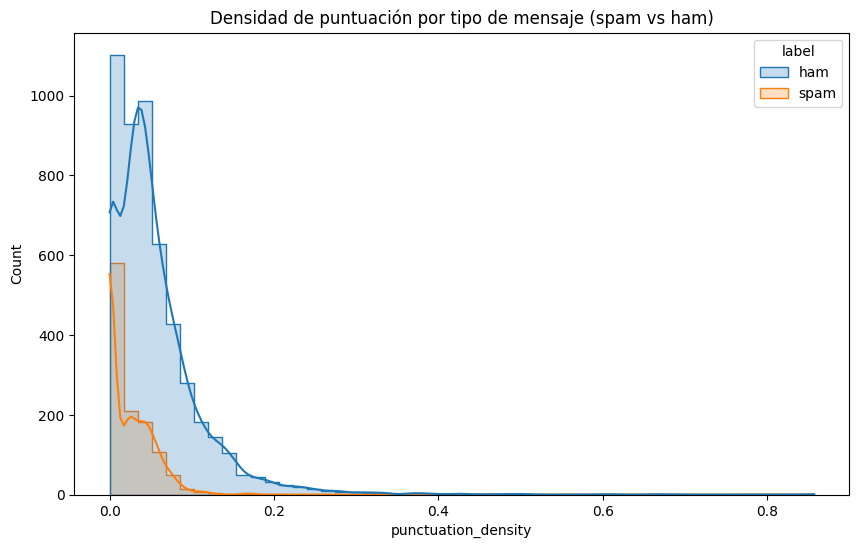

In [190]:
merged_df["punctuation_density"] = merged_df["punctuation_count"] / merged_df["message_length"]
plt.figure(figsize=(10,6))
sns.histplot(data=merged_df, x="punctuation_density", hue="label", kde=True, bins=50, element="step")
plt.title("Densidad de puntuación por tipo de mensaje (spam vs ham)")
plt.show()

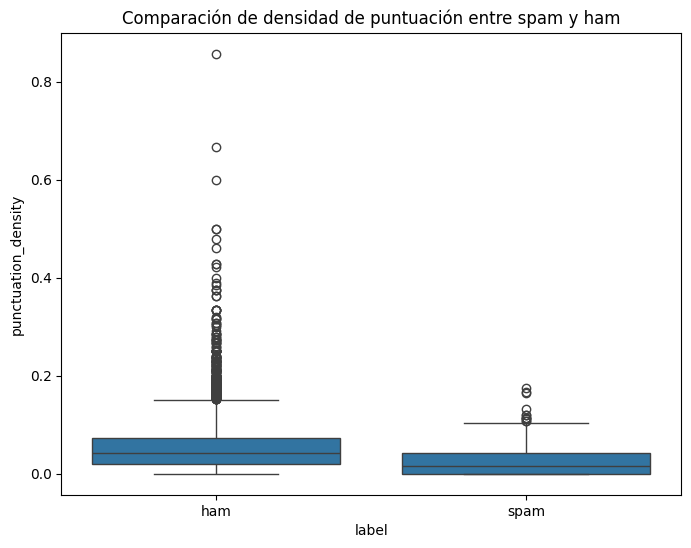

In [191]:
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x="label", y="punctuation_density")
plt.title("Comparación de densidad de puntuación entre spam y ham")
plt.show()

In [192]:
merged_df.groupby("label")["punctuation_density"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,5015.0,0.053993,0.055863,0.0,0.020779,0.041667,0.073171,0.857143
spam,1153.0,0.023092,0.027199,0.0,0.000000,0.015385,0.041667,0.175182


Al analizar la densidad de signos de puntuación (punctuation_density), se observa que los mensajes ham (legítimos) presentan, en promedio, una mayor proporción de signos de puntuación respecto a su longitud que los mensajes spam.

La media de densidad en ham es 0.0540, mientras que en spam es 0.0231.

La mediana en spam es más baja (0.015) e incluso el 25% de los mensajes spam no tiene ningún signo de puntuación (Q1 = 0.0). Lo cual se puede ver en los gráficos anteriores.



> Por otro lado, los ham usan puntuación de forma más constante, lo que sugiere que están redactados con más cuidado o naturalidad.



In [193]:
def get_top_ngrams(messages, ngram_range=(3, 3), top_n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(messages)
    sum_words = X.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return sorted(word_freq, key=lambda x: x[1], reverse=True)[:top_n]

**Hipótesis**
¿Los trigramas en mensajes spam son más directos y repetitivos que en mensajes legítimos?

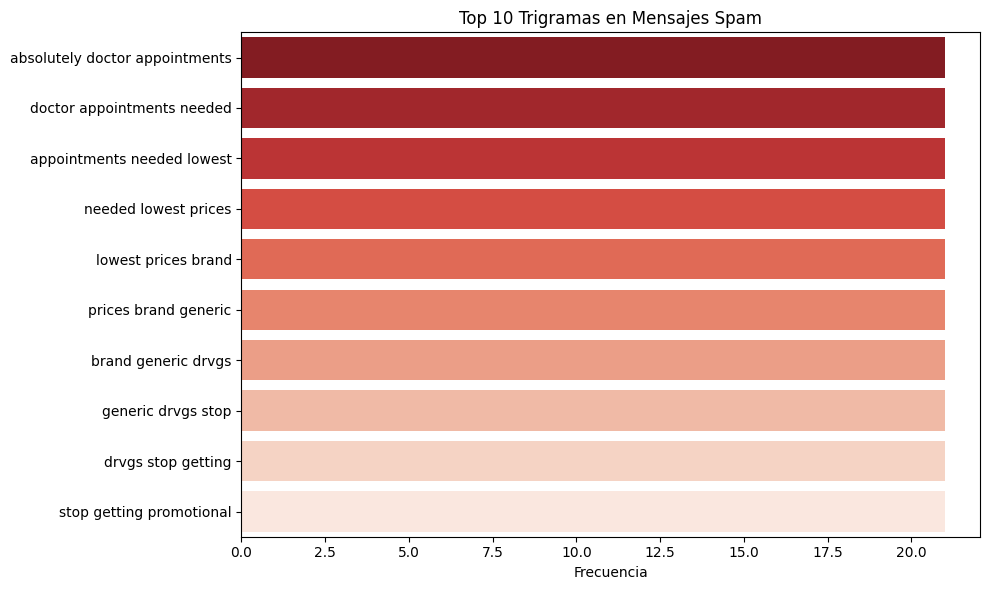

In [194]:
# Top trigramas en spam

top_spam_trigrams = get_top_ngrams(merged_df[merged_df['label'] == 'spam']['message'], ngram_range=(3, 3))
trigrams, freqs = zip(*top_spam_trigrams)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(freqs),
    y=list(trigrams),
    hue=list(trigrams),
    palette="Reds_r",
    legend=False
)
plt.title("Top 10 Trigramas en Mensajes Spam")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

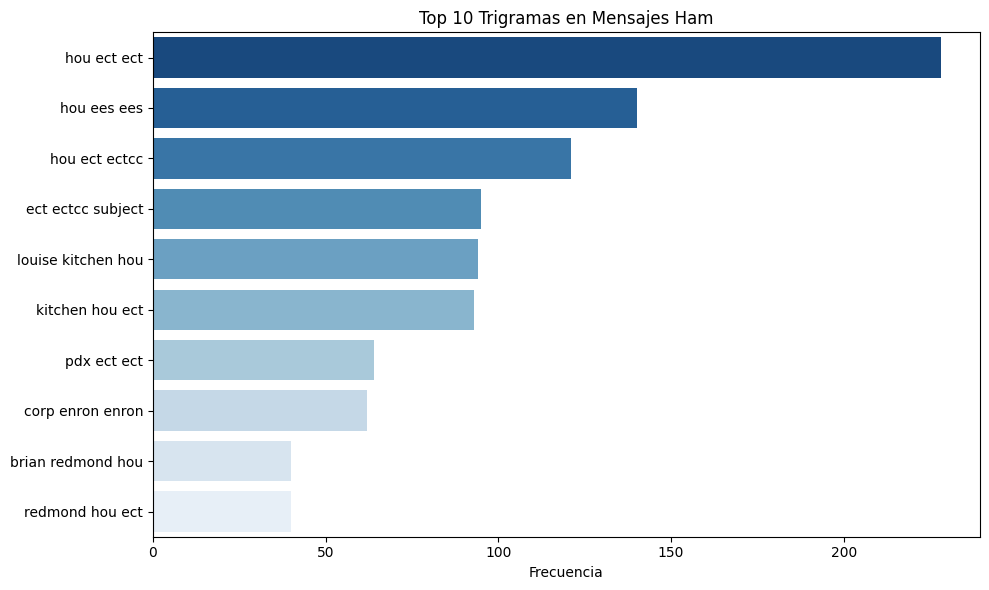

In [195]:
top_ham_trigrams = get_top_ngrams(merged_df[merged_df['label'] == 'ham']['message'], ngram_range=(3, 3))
trigrams, freqs = zip(*top_ham_trigrams)
plt.figure(figsize=(10, 6))
sns.barplot( x=list(freqs),
    y=list(trigrams),
    hue=list(trigrams),
    palette="Blues_r",
    legend=False
)
plt.title("Top 10 Trigramas en Mensajes Ham")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

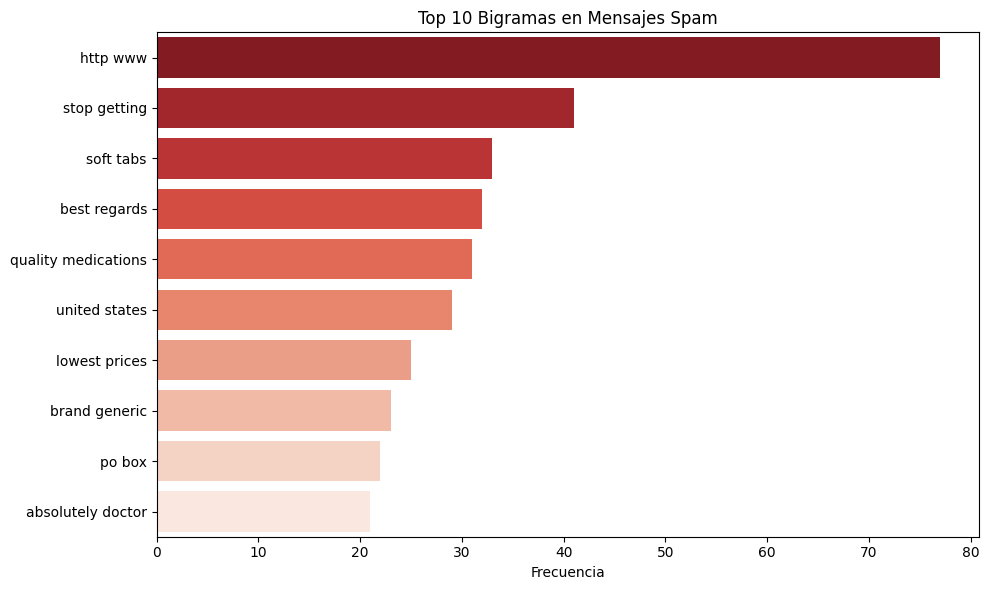

In [196]:
# Top bigramas en spam

top_spam_bigrams = get_top_ngrams(merged_df[merged_df['label'] == 'spam']['message'], ngram_range=(2, 2))
bigrams, freqs = zip(*top_spam_bigrams)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(freqs),
    y=list(bigrams),
    hue=list(bigrams),
    palette="Reds_r",
    legend=False
)
plt.title("Top 10 Bigramas en Mensajes Spam")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

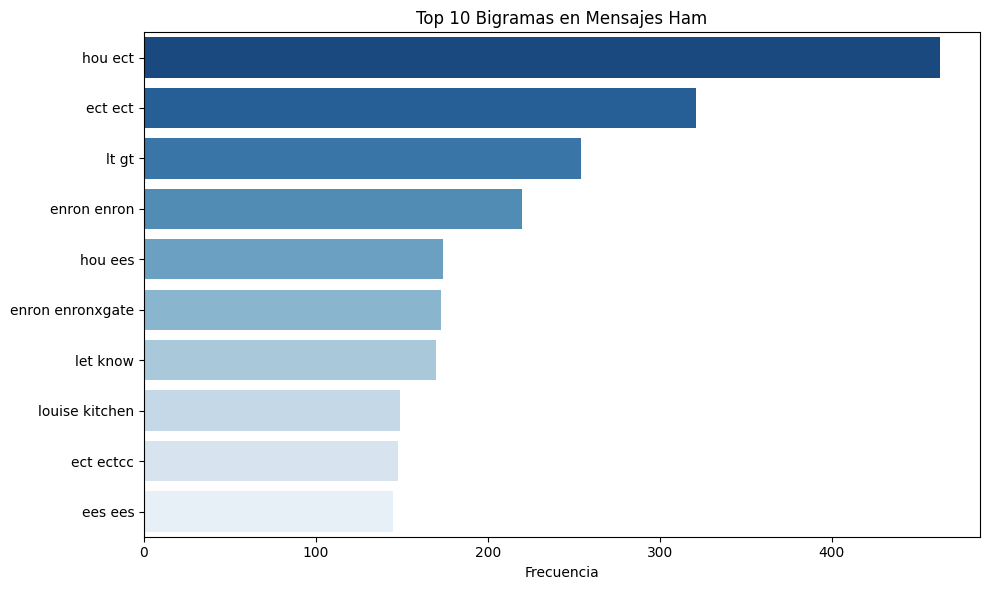

In [197]:
top_ham_bigrams = get_top_ngrams(merged_df[merged_df['label'] == 'ham']['message'], ngram_range=(2, 2))
bigrams, freqs = zip(*top_ham_bigrams)
plt.figure(figsize=(10, 6))
sns.barplot( x=list(freqs),
    y=list(bigrams),
    hue=list(bigrams),
    palette="Blues_r",
    legend=False
)
plt.title("Top 10 Bigramas en Mensajes Ham")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

Verificando si los n-gramas:
Los mensajes ham son más variados, conversacionales y extensos, lo que genera muchas combinaciones gramaticales comunes.
Los spam usan menos variedad, pero quizás algunos trigramas son muy específicos de spam.



> Lo importante no es cuánto aparecen, sino en qué clase aparecen más distintivamente.



<ipython-input-198-0feeb50d29c8>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_discriminative, x="spam_ratio", y="trigram", palette="Reds_r")


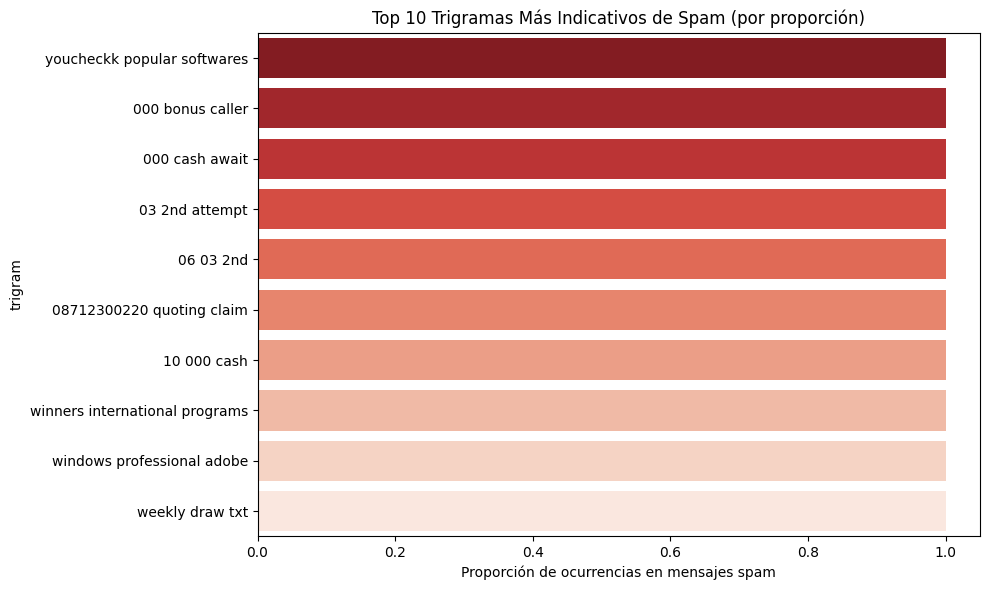

In [198]:
from collections import defaultdict

vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X = vectorizer.fit_transform(merged_df["message"])
trigram_vocab = vectorizer.get_feature_names_out()

# DataFrames por clase
X_spam = X[merged_df["label"].values == "spam"]
X_ham = X[merged_df["label"].values == "ham"]

# Suma de trigramas
spam_freq = X_spam.sum(axis=0).A1
ham_freq = X_ham.sum(axis=0).A1

trigram_data = pd.DataFrame({
    "trigram": trigram_vocab,
    "spam_freq": spam_freq,
    "ham_freq": ham_freq
})
trigram_data["total"] = trigram_data["spam_freq"] + trigram_data["ham_freq"]
trigram_data["spam_ratio"] = trigram_data["spam_freq"] / trigram_data["total"]

# Filtrar trigramas más frecuentes
top_discriminative = trigram_data[trigram_data["total"] >= 5].sort_values("spam_ratio", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_discriminative, x="spam_ratio", y="trigram", palette="Reds_r")
plt.title("Top 10 Trigramas Más Indicativos de Spam (por proporción)")
plt.xlabel("Proporción de ocurrencias en mensajes spam")
plt.tight_layout()
plt.show()

<ipython-input-199-bf2f0473dce2>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="Reds_r")


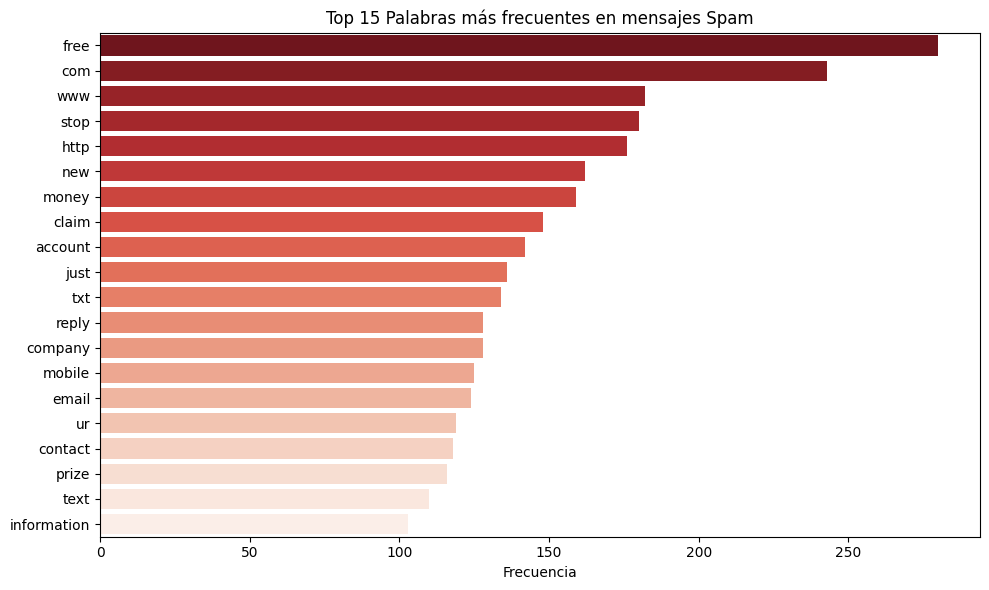

In [199]:
# Solo mensajes spam
spam_messages = merged_df[merged_df['label'] == 'spam']['message']
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(spam_messages)
sum_words = X.sum(axis=0)

# Obtener top 20 palabras
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
top_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:20]

words, freqs = zip(*top_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(freqs), y=list(words), palette="Reds_r")
plt.title("Top 15 Palabras más frecuentes en mensajes Spam")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

En el gráfico se puede observar una alta frecuencia de palabras como http, www y com en los mensajes clasificados como spam. Ello puede sugerir que los mensajes spam tienden a contener enlaces, lo cual es consistente con estrategias típicas de phishing o promociones fraudulentas. Este patrón refuerza la idea de que la presencia de URLs puede ser un indicador clave para distinguir entre mensajes legítimos y no deseados.

